In [1]:
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
dataset = 'classa'

In [3]:
# Read our results

import json

def combine_dict(dict1, dict2):
    for key in dict2.keys():
        if key in dict1:
            dict1[key] = combine_dict(dict1[key], dict2[key])
        else:
            dict1[key] = dict2[key]
    return dict1

def combine_dicts(dicts):
    u = None
    for d in dicts:
        if u is None:
            u = d
        else:
            u = combine_dict(u, d)
    return u

In [4]:
import site

site.addsitedir("/home/xyhang/projects/VCIP2023-grand-challenge/")

from tools.bdrate import BD_RATE, BD_PSNR

In [5]:
from dataclasses import dataclass
from typing_extensions import TypeAlias, List, Dict
import numpy as np

@dataclass
class ResultUnit:
    r: float
    d: float
    t: float

ImageResults: TypeAlias = List[ResultUnit]

class DatasetResults:
    def __init__(self):
        self.img_results: Dict[str, ImageResults] = {}

    def update_image_result(self, img_name, r, d, t):
        self.img_results.setdefault(img_name, []).append(ResultUnit(r=r, d=d, t=t))

    def sort(self):
        for k in self.img_results.keys():
            self.img_results[k].sort(key=lambda x: x.r)

    @property
    def avg_r(self) -> float:
        self.sort()
        results = []
        for rs in zip(*list(self.img_results.values())):
            results.append(np.mean([x.r for x in rs]))
        return results

    @property
    def avg_d(self) -> float:
        self.sort()
        results = []
        for rs in zip(*list(self.img_results.values())):
            results.append(np.mean([x.d for x in rs]))
        return results

    @property
    def avg_t(self) -> float:
        self.sort()
        results = []
        for rs in zip(*list(self.img_results.values())):
            results.append(np.mean([x.t for x in rs]))
        return results

    def bd_rate(self, anchor):
        self.sort()
        anchor.sort()
        ans = []
        for filename, data in self.img_results.items():
            if filename not in anchor.img_results:
                raise ValueError(f"filename {filename} not in anchor")
            data_anchor = anchor.img_results[filename]
            R1 = [x.r for x in data_anchor]
            D1 = [x.d for x in data_anchor]
            R2 = [x.r for x in data]
            D2 = [x.d for x in data]
            bd_rate = BD_RATE(R1, D1, R2, D2)
            print(filename, bd_rate)
            ans.append(bd_rate)
        return np.mean(ans)

    def bd_psnr(self, anchor):
        self.sort()
        anchor.sort()
        ans = []
        for filename, data in self.img_results.items():
            if filename not in anchor.img_results:
                raise ValueError(f"filename {filename} not in anchor")
            data_anchor = anchor.img_results[filename]
            R1 = [x.r for x in data_anchor]
            D1 = [x.d for x in data_anchor]
            R2 = [x.r for x in data]
            D2 = [x.d for x in data]
            bd_rate = BD_PSNR(R1, D1, R2, D2)
            ans.append(bd_rate)
        return np.mean(ans)

In [6]:
def read_json(filename):
    with open(filename, 'r') as f:
        return json.load(f)

In [7]:
import glob

results = glob.glob(f"{dataset}/*.json")

data_ours = combine_dicts([read_json(r) for r in results])

In [8]:
speedups = [0.01, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 2.0, 3.0]
qscales = [0.3, 0.4, 0.5, 0.6, 0.7]

In [9]:
ours_results = {k: DatasetResults() for k in speedups}

for speedup in speedups:
    for qscale in qscales:
        glob_results = data_ours[f"qscale={qscale}"][f"speedup={speedup}"]
        for filename, result in glob_results.items():
            if filename[:3] != "avg":
                ours_results[speedup].update_image_result(
                    filename, result["bpp"], result["PSNR"], result["t_dec"]
                )

In [10]:
import pandas as pd

def read_xls(file_path, sheet_name):
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    return df

In [11]:
anchors = ['bpg', 'evc', 'jpeg', 'mlic', 'qarv', 'tcm', 'vtm', 'webp']

anchor_results: Dict[str, DatasetResults] = {k: DatasetResults() for k in anchors}

anchors_r = {}
anchors_d = {}
anchors_t = {}

for anchor in anchors:
    if anchor == 'vtm':
        xls_data: pd.DataFrame = read_xls(f"VTM.xls", dataset)
        filename = None
        for index, x in xls_data.iterrows():
            if isinstance(x.Filename, str):
                filename = x.Filename
            anchor_results[anchor].update_image_result(
                filename, x.bpp, x["RGB psnr"], x["Dec Time"]
            )
    else:
        anchor_data = read_json(f"../../anchors/{dataset}/{anchor}/results.json")
        if anchor == 'bpg':
            for t1 in anchor_data.values():
                for t2 in t1.values():
                    for filename, result in t2.items():
                        if filename[:3] != "avg":
                            anchor_results[anchor].update_image_result(
                                filename, result["bpp"], result["PSNR"], result["t_dec"]
                            )
        else:
            for t2 in anchor_data.values():
                for filename, result in t2.items():
                    if filename[:3] != "avg":
                        anchor_results[anchor].update_image_result(
                            filename, result["bpp"], result["PSNR"], result["t_dec"]
                        )

bpg [28.600891832295385, 30.283618175768183, 31.84880266962779, 33.42348046976658, 35.41197474179996, 37.32295456407798, 39.584965237759874, 41.96530477830104, 44.250613988720694, 46.00518731620989] [0.02452186149792006, 0.04494741720106713, 0.07837762345083721, 0.13798181713797267, 0.25805898984201714, 0.44998837563245697, 0.7755209608764161, 1.267312805276002, 1.921515299675548, 2.6939712210928195]
evc [28.781016547265974, 29.336897958103147, 30.072602981113718, 30.873529989305464, 31.753680498682783] [0.1595719900978699, 0.21096965133019183, 0.2739667873912793, 0.39770654514456005, 0.5809845311167988]
jpeg [23.309772316399542, 28.92682537812325, 32.062470370315836, 33.68431287883056, 34.596312223656305, 35.26604464032583, 35.86974556623233, 36.71852954107853, 37.86821045357319, 40.00254376856817, 46.5620160918895] [0.1438243301156751, 0.2145674189438238, 0.31969320591908806, 0.4230462091250787, 0.5070015276522168, 0.5917880942920993, 0.6869732393814271, 0.8403496271193557, 1.0949162

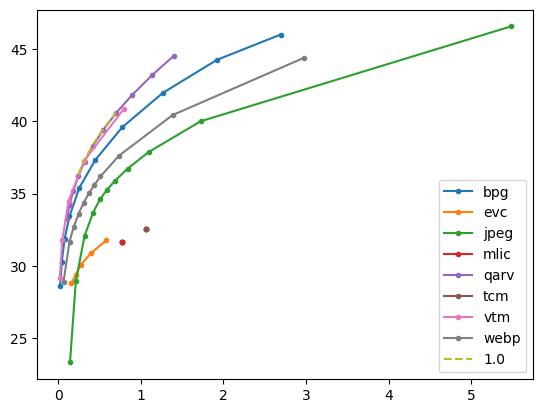

In [21]:
for k, v in anchor_results.items():
    print(k, v.avg_d, v.avg_r)
    plt.plot(v.avg_r, v.avg_d, label=k, marker='.')

for speedup in [1.0]:

    plt.plot(
        ours_results[speedup].avg_r,
        ours_results[speedup].avg_d,
        linestyle="--",
        label=speedup,
    )
plt.legend()
plt.show()

In [17]:
anchor_results['qarv'].bd_rate(anchor_results['vtm'])

DOG_4507 0.6715892648608834
DSC07099 8.764764495489686
DSC07705 -4.403112620455351
DSC08582 8.3447409284793
DSC08626 16.34033861096742
DSC08672 2.141283113168768
DSC08796 5.199929803728898
DSC08892 0.4332666375583605
DSC08902 25.92206604578482
DSC08928 2.553496684733192
DSC08936 19.19308050823858
DSC_3889 -2.3013400956596652
IMG_1813 5.7088071001512475
IMG_3227 26.319328047357125
IMG_3261 20.25796351028786
IMG_3412 -1.4604987385232082
IMG_3515 -1.235948203770454
IMG_3799 8.540223741036446
IMG_4684 1.2522282013875063
IMG_4700 0.5307686583082338
IMG_6726 3.670101479333443
IMG_7136 14.485794736127012
IMG_8176 12.332218817001861
IMG_8795 33.02895323343249


8.595418498292686

In [22]:
anchor_results['mlic'].img_results

{'DOG_4507': [ResultUnit(r=0.6515545590643541, d=18.31984331586294, t=46.39095735549927),
  ResultUnit(r=0.6515545590643541, d=18.31984331586294, t=40.086798429489136),
  ResultUnit(r=0.6515545590643541, d=18.31984331586294, t=40.90150189399719),
  ResultUnit(r=0.6515545590643541, d=18.31984331586294, t=44.65595817565918),
  ResultUnit(r=0.6515545590643541, d=18.31984331586294, t=43.850300550460815)],
 'DSC07099': [ResultUnit(r=1.1679013333333332, d=38.67762913682394, t=35.69063472747803),
  ResultUnit(r=1.1679013333333332, d=38.67762913682394, t=37.63072180747986),
  ResultUnit(r=1.1679013333333332, d=38.67762913682394, t=33.5056734085083),
  ResultUnit(r=1.1679013333333332, d=38.67762913682394, t=32.8505277633667),
  ResultUnit(r=1.1679013333333332, d=38.67762913682394, t=33.15197515487671)],
 'DSC07705': [ResultUnit(r=1.3348253333333333, d=39.608809256338404, t=34.56576323509216),
  ResultUnit(r=1.3348253333333333, d=39.608809256338404, t=35.264923334121704),
  ResultUnit(r=1.334825

In [18]:
ours_results[1.0].img_results["DSC08582"]

[ResultUnit(r=0.111838, d=34.59656407811575, t=7.004122018814087),
 ResultUnit(r=0.15802633333333332, d=35.056889557623194, t=6.711113452911377),
 ResultUnit(r=0.2859776666666667, d=35.93464186170034, t=7.957449197769165),
 ResultUnit(r=0.5346936666666666, d=37.41460731007986, t=9.545718908309937),
 ResultUnit(r=0.8464226666666667, d=39.11912968137197, t=9.798119306564331)]

In [19]:
ours_results[1.0].bd_rate(anchor_results["vtm"])

DOG_4507 -7.160483448580757
DSC07099 2.569438518850631
DSC07705 -7.457320174363202
DSC08582 4.790886850259035
DSC08626 3.123450351795798
DSC08672 -0.5137955105564918
DSC08796 1.6610288973274878
DSC08892 -7.913573947311803
DSC08902 7.126521562800425
DSC08928 -5.7433767915391005
DSC08936 1.919416240202021
DSC_3889 -8.411498182597022
IMG_1813 -1.0160409994273034
IMG_3227 1.3032148011393296
IMG_3261 2.9540333060785295
IMG_3412 -8.470568211565432
IMG_3515 -7.97644370035192
IMG_3799 -3.5568768349893976
IMG_4684 -4.907141790469716
IMG_4700 -4.797378268415942
IMG_6726 -4.72208657904053
IMG_7136 8.663630321939175
IMG_8176 4.339522687875608
IMG_8795 3.8156693520091434


-1.2658238145388099

In [20]:
ours_results[1.0].bd_rate(anchor_results['qarv'])

DOG_4507 -1.9803538337364035
DSC07099 -0.8713983097984102
DSC07705 -0.15588270861085496
DSC08582 -1.1758278329208394
DSC08626 -2.331735048570094
DSC08672 -0.23319853725128903
DSC08796 -0.6226177895340745
DSC08892 -3.900098091478843
DSC08902 -3.345087277277914
DSC08928 -1.955205673900673
DSC08936 -3.618001171430152
DSC_3889 -0.06826781157864836
IMG_1813 -0.2514258709149675
IMG_3227 -4.172526457902348
IMG_3261 -3.8970745123768635
IMG_3412 -1.547374238386856
IMG_3515 -2.312244817642617
IMG_3799 -1.6917699148478293
IMG_4684 -1.1668401113377969
IMG_4700 -2.5566250476707797
IMG_6726 -3.7387223939160386
IMG_7136 -0.3327221104147182
IMG_8176 -2.530012068144405
IMG_8795 -4.393841075783811


-2.0353688627261346